# FANN Implementation

### Imports and Definitions of Classes and Utility Functions

In [125]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
import imageio
from matplotlib.lines import Line2D
import os

def create_neural_network_graph(layer_sizes):
    G = nx.DiGraph()
    pos = {} # Position of nodes in the graph
    # Add nodes in layers
    for i, layer_size in enumerate(layer_sizes):
        for j in range(layer_size):
            G.add_node((i, j))  # Node represented as an integer
            pos[(i, j)] = (i, j)
    # Connect nodes between layers
    for i in range(len(layer_sizes) - 1):
        for j in range(layer_sizes[i]):
            for k in range(layer_sizes[i + 1]):
                G.add_edge((i, j), (i + 1, k))
    return G,pos

def make_network(num_classes, layers, inhibitory_layers=None):
    if layers[0] % num_classes != 0:
        raise ValueError('First layer must be divisible by number of classes')
    if layers[-1] % num_classes != 0:
        raise ValueError('Last layer must be divisible by number of classes')
    G,pos = create_neural_network_graph(layers)
    N = len(G.nodes)

    cum_layers = np.cumsum(layers)
    inputs = {i: np.arange(cum_layers[0]//num_classes*i, cum_layers[0]//num_classes*(i+1)) for i in range(num_classes)}
    all_inputs = set([int(i) for i in np.arange(cum_layers[0])])
    outputs = {num_classes-i-1: np.arange(N - layers[-1]//num_classes*(i+1), N - layers[-1]//num_classes*i) for i in range(num_classes)}
    all_outputs = set([int(i) for i in np.arange(cum_layers[-2], cum_layers[-1])])
    inhibitory = np.zeros(N).astype(bool)
    
    return G, pos, N, inputs, all_inputs, outputs, all_outputs, inhibitory

class FANN:
    def __init__(self, G, pos, inputs, all_inputs, outputs, all_outputs, inhibitory,
                 rounds=10000,
                 restructure=False, restructure_num=None, verbose=False):
        self.G = G
        self.A = nx.adjacency_matrix(G).T.astype(bool)
        self.ORG_A = self.A.copy()
        self.pos = pos
        self.inputs = inputs
        self.all_inputs = all_inputs
        self.outputs = outputs
        self.all_outputs = all_outputs
        self.inhibitory = inhibitory
        self.N = len(G.nodes)
        self.verbose = verbose
        self.restructure = restructure

        # HYPERPARAMETERS
        self.CONDITIONING_ROUNDS = 10
        self.ROUNDS = rounds
        self.INPUTS_PER_ROUND = 2
        self.CLICKS_PER_INPUT = 10
        self.FEEDBACKS_PER_ROUND_CORRECT = 0
        self.CLICKS_PER_FEEDBACK_CORRECT = 10
        self.FEEDBACKS_PER_ROUND_INCORRECT = 2
        self.CLICKS_PER_FEEDBACK_INCORRECT = 100
        self.ACTIVATION_THRESHOLD = 1
        self.OPTIMAL_STD_REF = 50
        self.STOP_AFTER_STREAK = 100
        self.STARTING_CONNECTIONS_PER_NODE = 2

        # restructure (starting connections per node)
        if self.restructure:
            if restructure_num is None:
                restructure_num = self.STARTING_CONNECTIONS_PER_NODE
            for i in range(self.N):
                options = [x for x in self.ORG_A[[i], :].nonzero()[1]]
                if len(options) < restructure_num:
                    continue
                option_choices = np.random.choice(options, size=self.STARTING_CONNECTIONS_PER_NODE, replace=False)
                self.A[i, options] = False
                self.A[i, option_choices] = True

        # running variables
        self.t = 0
        self.s = np.random.choice([False, True], size=(self.N), p=[1.0,0.0])
        self.correct_count = 0
        self.correct_streak = 0
        self.CLICKS = self.CONDITIONING_ROUNDS*self.INPUTS_PER_ROUND*self.CLICKS_PER_INPUT + self.ROUNDS*self.INPUTS_PER_ROUND*self.CLICKS_PER_INPUT + self.ROUNDS*max(self.FEEDBACKS_PER_ROUND_CORRECT, self.FEEDBACKS_PER_ROUND_INCORRECT)*max(self.CLICKS_PER_FEEDBACK_CORRECT, self.CLICKS_PER_FEEDBACK_INCORRECT)

        # tracking variables
        self.s_tracking = np.zeros((self.CLICKS, self.N))
        self.diffs_tracking = np.zeros((self.CLICKS, self.N))
        self.branching_factors_tracking = np.zeros((self.CLICKS, self.N))
        self.a_data_tracking = np.zeros((self.CLICKS, (self.ORG_A != 0).sum()))

        if self.verbose:
            print('Max Clicks:', self.CLICKS)
            print('Optimal STD Reference:', self.OPTIMAL_STD_REF)

    def set_A(self, A):
        self.A = A

    def draw(self, title=None, ax=None, always_active=None):
        colors = []
        for i in range(self.N):
            if always_active is not None and i in always_active:
                colors.append('g')
            elif self.inhibitory[i]:
                colors.append('b')
            else:
                colors.append('r')
        nx.draw(self.G, self.pos, node_color=colors, ax=ax)
        if title is not None:
            if ax is not None:
                ax.set_title(title)
            else:
                plt.title(title)
        labels = {}
        for i in range(self.N):
            if i in self.all_inputs:
                labels[i] = '▲'
            elif i in self.all_outputs:
                labels[i] = '▼'
        nx.draw_networkx_labels(self.G, self.pos, labels, font_size=8, ax=ax)
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Excitatory', markerfacecolor='r', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Inhibitory', markerfacecolor='b', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Always Active', markerfacecolor='g', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Input (▲)', markerfacecolor='gray', markersize=10),
            Line2D([0], [0], marker='o', color='w', label='Output (▼)', markerfacecolor='gray', markersize=10),
        ]
        plt.legend(handles=legend_elements)
        if ax is None:
            plt.show()

    def stimulation_diff(self):
        WINDOW = 1000
        if self.t < WINDOW:
            return np.zeros(self.N)
        time_gaps = [np.diff(np.where(x)[0]) for x in self.s_tracking[self.t-WINDOW:self.t].T]
        time_stds = np.array([x.std() for x in time_gaps])
        return time_stds

    def stimulation_adjustment(self):
        incoming_counts = (self.ORG_A != 0).sum(axis=1) # number of incoming connections by node
        branching_factors = (self.diffs / self.OPTIMAL_STD_REF / 10) ** 2
        branching_factors[self.diffs <= self.OPTIMAL_STD_REF] = 0
        branching_factors = np.clip(branching_factors, a_min=0, a_max=0.02)
        # do not change if branching factor has decreased by 20%
        decrease = self.branching_factors_tracking[self.t-500] >= branching_factors * 1.1
        branching_factors[decrease] = 0
        #branching_factors = diff_to_branching_factors(diffs)
        branching_data = np.repeat(branching_factors, incoming_counts)
        switch_data = np.random.rand(len(branching_data)) < branching_data
        self.A.data ^= switch_data
        # ensure each node has at least one incoming connection
        incoming_active = (self.A != 0).sum(axis=1)
        no_incoming = (incoming_active == 0) & (incoming_counts != 0)
        for i in np.where(no_incoming)[0]:
            options = [x for x in self.ORG_A[[i], :].nonzero()[1]]
            option_choice = np.random.choice(options)
            self.A[i, option_choice] = True
        # tracking
        self.a_data_tracking[self.t] = self.A.data
        self.branching_factors_tracking[self.t] = branching_factors

    def propagate_and_learn(self, learn=False):
        self.s_tracking[self.t] = self.s
        if learn:
            self.diffs = self.stimulation_diff()
            self.diffs_tracking[self.t] = self.diffs
            self.stimulation_adjustment()
        else:
            self.diffs_tracking[self.t] = self.diffs_tracking[self.t-1] if self.t > 0 else 0
            self.branching_factors_tracking[self.t] = self.branching_factors_tracking[self.t-1] if self.t > 0 else 0
            self.a_data_tracking[self.t] = self.a_data_tracking[self.t-1] if self.t > 0 else 0
        self.s = self.A.dot(np.where(self.inhibitory, -1*self.s, self.s)) >= self.ACTIVATION_THRESHOLD

    def _draw_vlines(self, ax=None):
        for i in range(len(self.feedback_correct_start_times)):
            if ax is not None:
                ax.axvline(x=self.feedback_correct_start_times[i], color='g', alpha=0.5, linestyle='--')
            else:
                plt.axvline(x=self.feedback_correct_start_times[i], color='g', alpha=0.5, linestyle='--')
        for i in range(len(self.feedback_incorrect_start_times)):
            if ax is not None:
                ax.axvline(x=self.feedback_incorrect_start_times[i], color='r', alpha=0.5, linestyle='--')
            else:
                plt.axvline(x=self.feedback_incorrect_start_times[i], color='r', alpha=0.5, linestyle='--')

    def summary_plot(self, window=None, draw_vlines=False):
        nodes_to_plot = list(set([int(i) for i in np.arange(self.N)]) - self.all_inputs)
        node_names = [list(self.G.nodes())[i] for i in nodes_to_plot]

        fig, axs = plt.subplots(1, 2, figsize=(14,8))

        if draw_vlines:
            self._draw_vlines(ax=axs[0])
        axs[0].set_title('Branching Factors vs. Clicks')
        axs[0].plot(self.branching_factors_tracking[:, nodes_to_plot], label=node_names)
        axs[0].legend(title='Node')
        if window is not None:
            axs[0].set_xlim(window)
        
        if draw_vlines:
            self._draw_vlines(ax=axs[1])
        axs[1].set_title('Connections vs. Clicks')
        axs[1].plot(self.a_data_tracking, label=np.array(self.ORG_A.nonzero()).T, alpha=0.5)
        axs[1].legend(title='Connection')
        if window is not None:
            axs[1].set_xlim(window)

        plt.suptitle('Branching and Connections vs. Clicks')
        plt.tight_layout()
        plt.show()

    def connection_movie(self, every_n_frames=1):
        max_frames = len(self.feedback_start_times)-1
        for i in range(max_frames):
            if i % every_n_frames != 0:
                continue
            t = self.feedback_start_times[i]
            curr_A = self.A.copy()
            curr_A.data = self.a_data_tracking[t]
            curr_G = nx.from_numpy_array(curr_A.T.toarray(), create_using=nx.DiGraph)
            node_names = list(self.G.nodes())
            curr_G = nx.relabel_nodes(curr_G, {i : node_names[i] for i in range(self.N)})
            nx.draw(curr_G, self.pos)
            plt.savefig(f'movie/frame-{i}.png')
            plt.close()
        png_files = sorted([f for f in os.listdir('movie') if f.startswith('frame') and f.endswith('.png')], key=lambda x: int(x.split('-')[1].split('.')[0]))
        print(png_files)
        output_file = 'connection-movie.mp4'
        with imageio.get_writer(output_file, fps=10) as writer:
            for png_file in png_files:
                image_path = os.path.join('movie', png_file)
                image = imageio.imread(image_path)
                writer.append_data(image)
        # cleanup
        for png_file in png_files:
            os.remove(os.path.join('movie', png_file))

    def connection_plt(self, frames, structure=None, figsize=(10,10), node_size=1000, title=None):
        if structure is None:
            structure = (frames, 1)
        
        if structure[0] * structure[1] != frames:
            raise ValueError('structure[0] * structure[1] must equal frames')
        
        fig, axs = plt.subplots(structure[0], structure[1], figsize=figsize)
        max_frames = len(self.feedback_start_times)-1
        # determine the number of frames to skip
        skip = (max_frames + 1) // (frames - 1)
        axs_loc = [0, 0]
        for i in range(max_frames+1):
            if i % skip != 0:
                continue
            t = self.feedback_start_times[i]
            curr_A = self.A.copy()
            curr_A.data = self.a_data_tracking[t]
            curr_G = nx.from_numpy_array(curr_A.T.toarray(), create_using=nx.DiGraph)
            node_names = list(self.G.nodes())
            node_names_to_numbers = {node_names[i]: i for i in range(self.N)}
            #curr_G = nx.relabel_nodes(curr_G, {i : node_names[i] for i in range(self.N)})
            curr_pos = {node_names_to_numbers[k]: v for k, v in self.pos.items()}
            if structure[0] == 1:
                curr_ax = axs[axs_loc[1]]
            else:
                curr_ax = axs[axs_loc[0], axs_loc[1]]
            nx.draw(curr_G, curr_pos, ax=curr_ax, node_size=node_size, with_labels=True)
            curr_ax.set_title(f'Round {i}')
            if axs_loc[1] == structure[1] - 1:
                axs_loc[0] += 1
                axs_loc[1] = 0
            else:
                axs_loc[1] += 1
        if title is not None:
            fig.suptitle(title)
        else:
            fig.suptitle('Connection Evolution')
        plt.tight_layout()
        plt.show()
            
    def run(self):
        time_start = time.time()
        input_start_times = []
        feedback_start_times = []
        feedback_correct_start_times = []
        feedback_incorrect_start_times = []

        for round_i in range(self.CONDITIONING_ROUNDS):
            round_input = np.random.choice(list(self.inputs.keys()))
            x = self.inputs[round_input]
            for _ in range(self.INPUTS_PER_ROUND):
                self.s[x] = True
                for i in range(self.CLICKS_PER_INPUT):
                    self.propagate_and_learn(learn = i == self.CLICKS_PER_INPUT - 1)
                    self.t += 1 # time step

        if self.verbose:
            print('Conditioning Done at', self.t)    

        for round_i in range(self.ROUNDS):
            round_input = np.random.choice(list(self.inputs.keys()))
            x = self.inputs[round_input]
            y = self.outputs[round_input]
            y_not = np.array(list(self.all_outputs - set(y)))
            
            points = 0
            for _ in range(self.INPUTS_PER_ROUND):
                self.s[x] = True
                for i in range(self.CLICKS_PER_INPUT):
                    
                    self.propagate_and_learn(learn = i == self.CLICKS_PER_INPUT - 1)

                    y_sum = self.s[y].sum()
                    y_not_sum = self.s[y_not.astype('int')].sum()
                    if y_sum > y_not_sum:
                        points += 1
                    elif y_sum < y_not_sum:
                        points -= 1

                    self.t += 1 # time step


            feedback_start_times.append(self.t)
            
            correct = points > 0
            if correct:
                if self.verbose:
                    print('Correct', round_i, self.t)
                self.correct_count += 1
                feedback_correct_start_times.append(self.t)
                if round_i - self.correct_streak > self.STOP_AFTER_STREAK:
                    break
            else:
                if self.verbose:
                    print('Incorrect', round_i, self.t)
                self.correct_streak = round_i + 1
                feedback_incorrect_start_times.append(self.t)
            feedbacks_per_round = self.FEEDBACKS_PER_ROUND_CORRECT if correct else self.FEEDBACKS_PER_ROUND_INCORRECT
            for _ in range(feedbacks_per_round):
                all_inputs_array = np.array(list(self.all_inputs))
                if correct:
                    self.s[all_inputs_array] = True
                    pass
                else:
                    #random_inputs = np.random.choice([False, True], size=(N), p=[0.5, 0.5])
                    random_inputs = all_inputs_array[np.random.binomial(1, 0.5, size=len(all_inputs_array)).astype(bool)]
                    self.s[random_inputs] = True
                clicks_per_feedback = self.CLICKS_PER_FEEDBACK_CORRECT if correct else self.CLICKS_PER_FEEDBACK_INCORRECT
                for i in range(clicks_per_feedback):
                    self.propagate_and_learn(learn = i == clicks_per_feedback - 1)
                    self.t += 1
            input_start_times.append(self.t)

        self.tracking = self.s_tracking[:self.t]
        self.diffs_tracking = self.diffs_tracking[:self.t]
        self.branching_factors_tracking = self.branching_factors_tracking[:self.t]
        self.a_data_tracking = self.a_data_tracking[:self.t]

        self.input_start_times = input_start_times
        self.feedback_start_times = feedback_start_times
        self.feedback_correct_start_times = feedback_correct_start_times
        self.feedback_incorrect_start_times = feedback_incorrect_start_times

        time_execution = time.time() - time_start
        success = round_i - self.correct_streak > self.STOP_AFTER_STREAK

        if self.verbose:
            print('Successful:', success)
            print('Total Execution Time:', time_execution)
            print('Correct Count:', self.correct_count)
            print('Correct Streak Since t(click) = ', self.correct_streak)
            print('Total Clicks:', self.t)

        return success, time_execution, self.correct_count, self.correct_streak, self.t, self.A.toarray()
    
def investigate_binary_classification(num_rounds, structures=None, restructure=False, restructure_nums=None, verbose=False, fann_override=None):
    if restructure_nums is not None and (structures is None or len(structures) != 1):
        raise ValueError('If restructure_nums exist, then there can only be one structure')
    if structures is None:
        structures = [
            (2,2),

            (2,2,2),
            (2,2,2,2),
            (2,2,2,2,2),
            (2,2,2,2,2,2),

            (4,4),
            (8,8),
            (16,16),
            (32,32),
        ]
    using_restructure = True
    if restructure_nums is None:
        restructure_nums = [None]
        using_restructure = False
    
    successes = {}
    time_executions = {}
    correct_count = {}
    correct_sinces = {}
    total_ts = {}
    As = {}
    for structure_i in range(len(structures)):
        structure = structures[structure_i]
        for restructuring_num in restructure_nums:
            if verbose:
                print('Investigating Structure:', structure)
            if not using_restructure:
                successes[structure] = []
                time_executions[structure] = []
                correct_count[structure] = []
                correct_sinces[structure] = []
                total_ts[structure] = []
                As[structure] = []
            else:
                successes[restructuring_num] = []
                time_executions[restructuring_num] = []
                correct_count[restructuring_num] = []
                correct_sinces[restructuring_num] = []
                total_ts[restructuring_num] = []
                As[restructuring_num] = []
    
            for round_i in range(num_rounds):
                if fann_override is not None:
                    fann = fann_override[structure_i][round_i]
                else:
                    G,pos,N,inputs,all_inputs,outputs,all_outputs,inhibitory = make_network(2, structure)
                    fann = FANN(G, pos, inputs, all_inputs, outputs, all_outputs, inhibitory, restructure=restructure, restructure_num=restructuring_num)
                success, time_execution, correct, correct_since, t, A = fann.run()
                if not using_restructure:
                    successes[structure].append(success)
                    time_executions[structure].append(time_execution)
                    correct_count[structure].append(correct)
                    correct_sinces[structure].append(correct_since)
                    total_ts[structure].append(t)
                    As[structure].append(A)
                else:
                    successes[restructuring_num].append(success)
                    time_executions[restructuring_num].append(time_execution)
                    correct_count[restructuring_num].append(correct)
                    correct_sinces[restructuring_num].append(correct_since)
                    total_ts[restructuring_num].append(t)
                    As[restructuring_num].append(A)
                
    if verbose:
        print('')

    for structure in structures:
        if verbose:
            print('Structure:', structure)
            print('Success Rate:', np.mean(successes[structure]))
            print('Mean Time Execution:', np.mean(time_executions[structure]))
            print('10/90 Percentile Time Execution:', np.percentile(time_executions[structure], 10), np.percentile(time_executions[structure], 90))
            print('Mean Correct Count:', np.mean(correct_count[structure]))
            print('Mean Correct Since:', np.mean(correct_sinces[structure]))
            print('Mean Total Clicks:', np.mean(total_ts[structure]))
            print('10/90 Percentile Total Clicks:', np.percentile(total_ts[structure], 10), np.percentile(total_ts[structure], 90))
            print('')

    if not using_restructure:
        results = {
            'structures': structures,
            'mean_successes': [np.mean(successes[structure]) for structure in structures],
            'mean_time_executions': [np.mean(time_executions[structure]) for structure in structures],
            '10_percentile_time_executions': [np.percentile(time_executions[structure], 10) for structure in structures],
            '90_percentile_time_executions': [np.percentile(time_executions[structure], 90) for structure in structures],
            'mean_correct_count': [np.mean(correct_count[structure]) for structure in structures],
            'mean_correct_since': [np.mean(correct_sinces[structure]) for structure in structures],
            '10_percentile_correct_since': [np.percentile(correct_sinces[structure], 10) for structure in structures],
            '90_percentile_correct_since': [np.percentile(correct_sinces[structure], 90) for structure in structures],
            'mean_total_clicks': [np.mean(total_ts[structure]) for structure in structures],
            '10_percentile_total_clicks': [np.percentile(total_ts[structure], 10) for structure in structures],
            '90_percentile_total_clicks': [np.percentile(total_ts[structure], 90) for structure in structures],
        }
    else:
        results = {
            'restructure_nums': restructure_nums,
            'mean_successes': [np.mean(successes[restructuring_num]) for restructuring_num in restructure_nums],
            'mean_time_executions': [np.mean(time_executions[restructuring_num]) for restructuring_num in restructure_nums],
            '10_percentile_time_executions': [np.percentile(time_executions[restructuring_num], 10) for restructuring_num in restructure_nums],
            '90_percentile_time_executions': [np.percentile(time_executions[restructuring_num], 90) for restructuring_num in restructure_nums],
            'mean_correct_count': [np.mean(correct_count[restructuring_num]) for restructuring_num in restructure_nums],
            'mean_correct_since': [np.mean(correct_sinces[restructuring_num]) for restructuring_num in restructure_nums],
            '10_percentile_correct_since': [np.percentile(correct_sinces[restructuring_num], 10) for restructuring_num in restructure_nums],
            '90_percentile_correct_since': [np.percentile(correct_sinces[restructuring_num], 90) for restructuring_num in restructure_nums],
            'mean_total_clicks': [np.mean(total_ts[restructuring_num]) for restructuring_num in restructure_nums],
            '10_percentile_total_clicks': [np.percentile(total_ts[restructuring_num], 10) for restructuring_num in restructure_nums],
            '90_percentile_total_clicks': [np.percentile(total_ts[restructuring_num], 90) for restructuring_num in restructure_nums],  
        }
    return results

def set_cache_results(name, results):
    path = 'cache/'+name
    np.save(path, results)

def get_cache_results(name):
    path = 'cache/'+name+'.npy'
    if not os.path.exists(path):
        return None
    return np.load(path, allow_pickle=True).item()

def graph_results(results, indices, xlabel):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))

    # plot success rate
    axs[0, 0].plot(indices, results['mean_successes'])
    axs[0, 0].set_xlabel(xlabel)
    axs[0, 0].set_ylabel('Success Rate')
    axs[0, 0].set_xticks(indices)
    axs[0, 0].set_title(f'Success Rate vs {xlabel}')

    # plot time execution
    axs[0, 1].plot(indices, results['mean_time_executions'], label='Mean')
    axs[0, 1].fill_between(indices, results['10_percentile_time_executions'], results['90_percentile_time_executions'], alpha=0.2, label='10/90 Percentile')
    axs[0, 1].set_xlabel(xlabel)
    axs[0, 1].set_ylabel('Time Execution (s)')
    axs[0, 1].set_xticks(indices)
    axs[0, 1].set_yscale('log')
    #axs[0, 1].set_ylim([min(results['10_percentile_time_executions']), max(results['90_percentile_time_executions'])])
    axs[0, 1].legend()
    axs[0, 1].set_title(f'Time Execution vs {xlabel}')

    # plot correct since
    axs[1,0].plot(indices, results['mean_correct_since'])
    axs[1,0].fill_between(indices, results['10_percentile_correct_since'], results['90_percentile_correct_since'], alpha=0.2, label='10/90 Percentile')
    axs[1,0].set_xlabel(xlabel)
    axs[1,0].set_ylabel('Rounds To Solve')
    axs[1,0].set_xticks(indices)
    axs[1,0].set_yscale('log')
    #axs[1,0].set_ylim([min(results['10_percentile_correct_since']), max(results['90_percentile_correct_since'])])
    axs[1,0].legend()
    axs[1,0].set_title(f'Rounds To Solve vs {xlabel}')

    # plot total clicks
    axs[1,1].plot(indices, results['mean_total_clicks'], label='Mean')
    axs[1,1].fill_between(indices, results['10_percentile_total_clicks'], results['90_percentile_total_clicks'], alpha=0.2, label='10/90 Percentile')
    axs[1,1].set_xlabel(xlabel)
    axs[1,1].set_ylabel('Total Clicks')
    axs[1,1].set_xticks(indices)
    axs[1,1].set_yscale('log')
    #axs[1,1].set_ylim([min(results['10_percentile_total_clicks']), max(results['90_percentile_total_clicks'])])
    axs[1,1].legend()
    axs[1,1].set_title(f'Total Clicks vs {xlabel}')

    plt.suptitle(f'Performance of FANNs against {xlabel}')
    plt.tight_layout()
    plt.show()

### Theoretically Possible Logic Operations

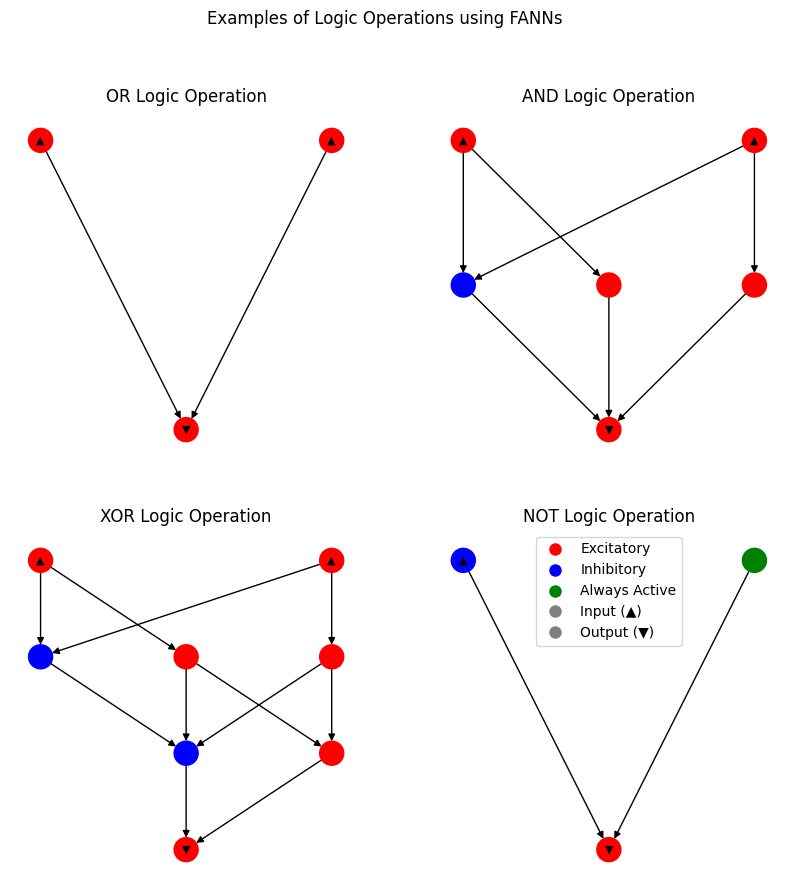

In [118]:
def draw_logic_operations():
    _, axs = plt.subplots(2, 2, figsize=(10,10))

    or_G = nx.from_numpy_array(np.array([[0, 0, 1], [0, 0, 1], [0,0,0]]), create_using=nx.DiGraph)
    or_pos = {0: (0, 0), 1: (-1, 0), 2: (-0.5, -1)}
    or_fann = FANN(or_G, or_pos, [], set([0,1]), [], set([2]), inhibitory=np.zeros(3).astype(bool), rounds=1000, verbose=False)
    or_fann.draw('OR Logic Operation', ax=axs[0, 0])

    and_G = nx.from_numpy_array(np.array([[0,0,1,0,1,0],[0,0,1,1,0,0],[0,0,0,0,0,1],[0,0,0,0,0,1],[0,0,0,0,0,1],[0,0,0,0,0,0]]), create_using=nx.DiGraph)
    and_pos = {0: (0, 0), 1: (-1, 0), 2: (-1, -1), 3: (-0.5, -1), 4: (0, -1), 5: (-0.5, -2)}
    and_inh = np.zeros(6).astype(bool)
    and_inh[2] = True
    and_fann = FANN(and_G, and_pos, [], set([0,1]), [], set([5]), inhibitory=and_inh, rounds=1000, verbose=False)
    and_fann.draw('AND Logic Operation', ax=axs[0, 1])

    xor_G = and_G = nx.from_numpy_array(np.array([[0,0,1,0,1,0,0,0],[0,0,1,1,0,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,1,1,0],[0,0,0,0,0,1,1,0],[0,0,0,0,0,0,0,1],[0,0,0,0,0,0,0,1],[0,0,0,0,0,0,0,0]]), create_using=nx.DiGraph)
    xor_pos = {0: (0, 0), 1: (-1, 0), 2: (-1, -1), 3: (-0.5, -1), 4: (0, -1), 5: (-0.5, -2), 6: (0, -2), 7: (-0.5, -3)}
    xor_inh = np.zeros(8).astype(bool)
    xor_inh[[2,5]] = True
    xor_fann = FANN(xor_G, xor_pos, [], set([0,1]), [], set([7]), inhibitory=xor_inh, rounds=1000, verbose=False)
    xor_fann.draw('XOR Logic Operation', ax=axs[1, 0])

    not_G = nx.from_numpy_array(np.array([[0,0,1],[0,0,1],[0,0,0]]), create_using=nx.DiGraph)
    not_pos = {0: (-1, 0), 1: (0, 0), 2: (-0.5, -1)}
    not_inh = np.zeros(3).astype(bool)
    not_inh[0] = True
    not_fann = FANN(not_G, not_pos, [], set([0]), [], set([2]), inhibitory=not_inh, rounds=1000, verbose=False)
    not_fann.draw('NOT Logic Operation', ax=axs[1, 1], always_active=[1])

    plt.suptitle('Examples of Logic Operations using FANNs')
    plt.show()

draw_logic_operations()

### Base Binary Classification Connection Evolution

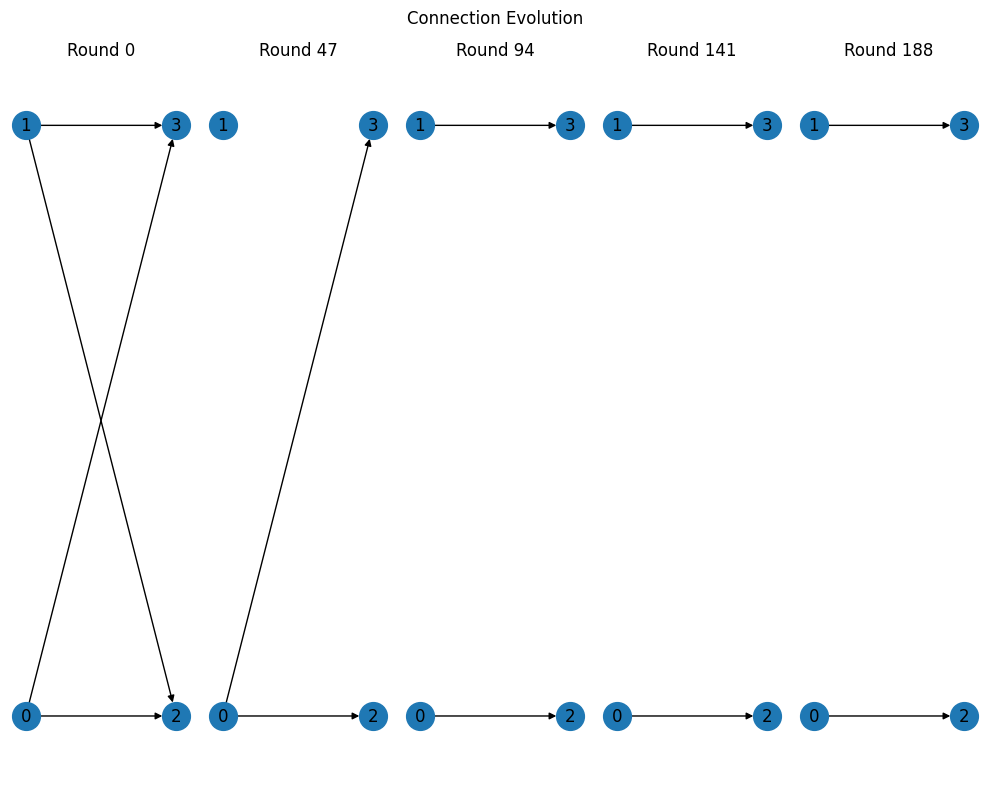

In [119]:
G,pos,N,inputs,all_inputs,outputs,all_outputs,inhibitory = make_network(2, [2, 2])
fann = FANN(G, pos, inputs, all_inputs, outputs, all_outputs, inhibitory, verbose=False, rounds=1000)
fann.run()
fann.connection_plt(frames=5, structure=(1,5), figsize=(10,8), node_size=400)

### Base Binary Classification Branching and Connections vs. Clicks

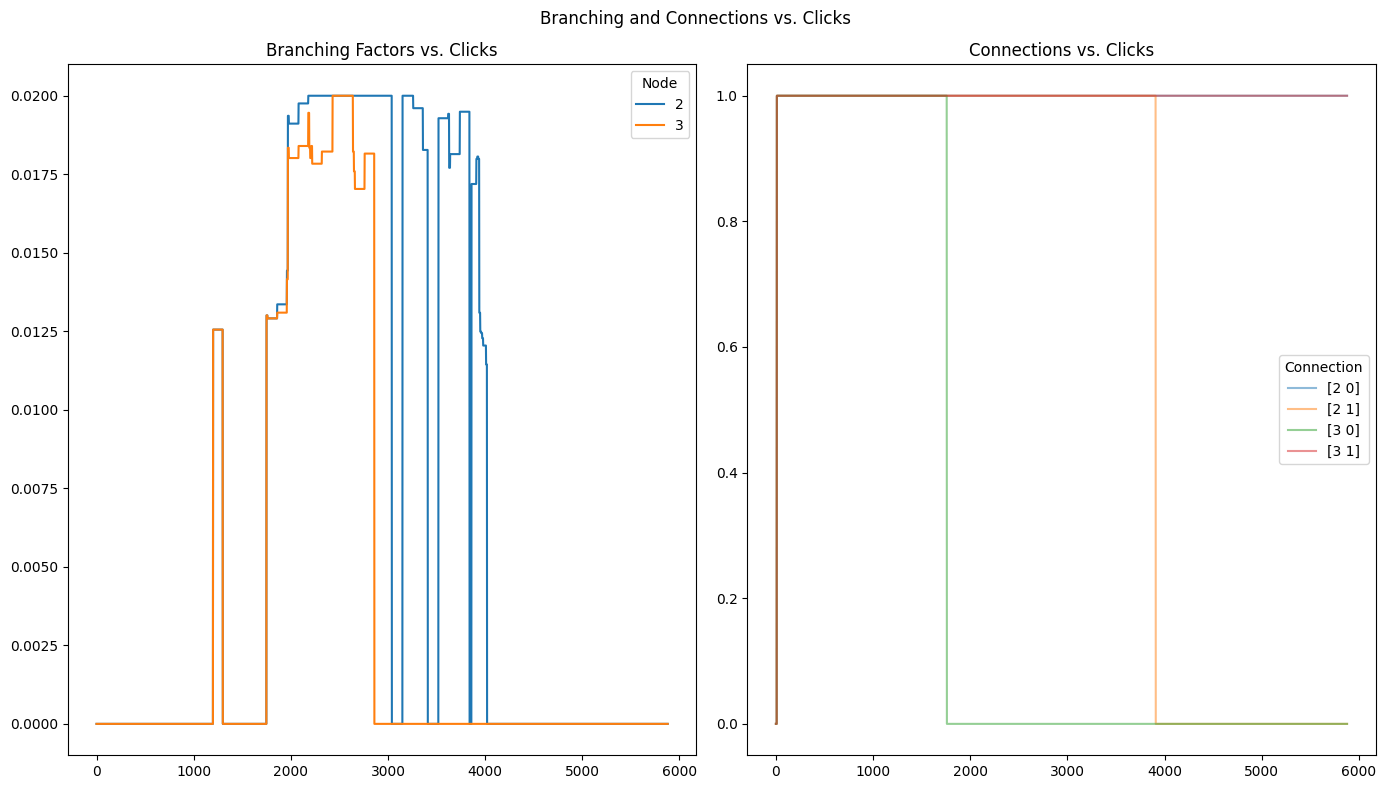

In [104]:
def investigate_base_binary_classification():
    G = nx.from_numpy_array(np.array([[0,0,1,1],[0,0,1,1],[0,0,0,0],[0,0,0,0]]).astype('bool'), create_using=nx.DiGraph)
    pos = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
    inputs = {0: [0], 1: [1]}
    all_inputs = set([0,1])
    outputs = {0: [2], 1: [3]}
    all_outputs = set([2,3])
    inhibitory = np.array([False, False, False, False])
    fann = FANN(G, pos, inputs, all_inputs, outputs, all_outputs, inhibitory, verbose=False)
    fann.run()
    fann.summary_plot()

investigate_base_binary_classification()

### Types of Network Features Examples

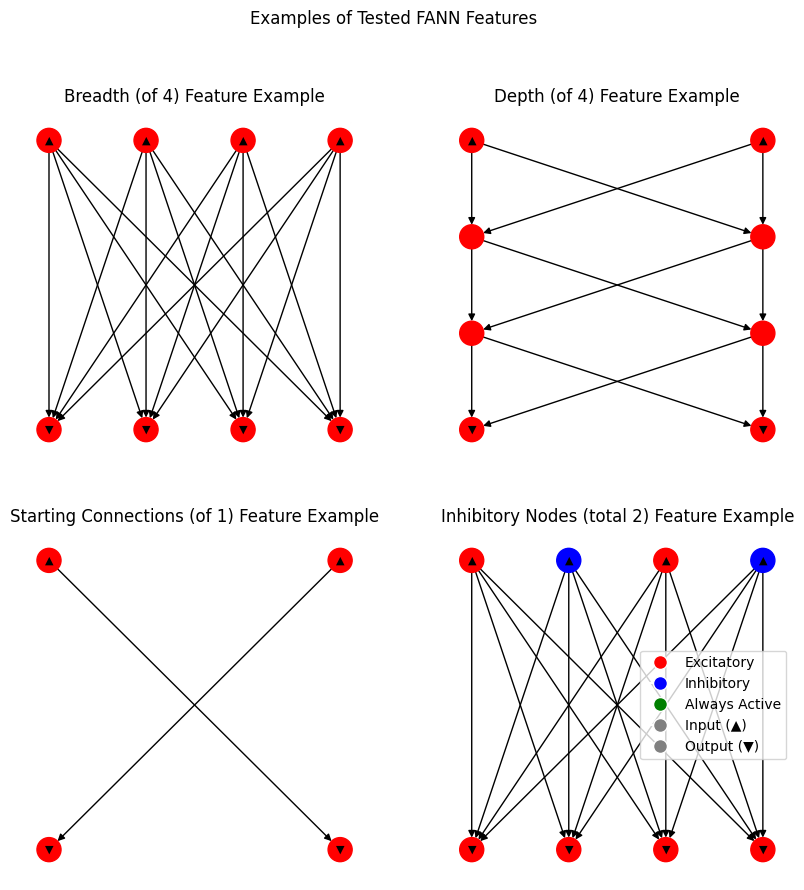

In [123]:
def draw_feature_types():
    _, axs = plt.subplots(2, 2, figsize=(10,10))

    breadth_G = nx.from_numpy_array(
        np.array([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1],
                  [0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
                  ])
        , create_using=nx.DiGraph)
    breadth_pos = {0: (0, 0), 1: (1, 0), 2: (2, 0), 3: (3, 0), 4: (0, -1), 5: (1, -1), 6: (2, -1), 7: (3, -1)}
    breadth_inhibitory = np.zeros(8).astype(bool)
    breadth_fann = FANN(breadth_G, breadth_pos, [], set([0,1,2,3]), [], set([4,5,6,7]), breadth_inhibitory, rounds=1000, verbose=False)
    breadth_fann.draw('Breadth (of 4) Feature Example', ax=axs[0, 0])

    depth_G = nx.from_numpy_array(
        np.array([[0,0,1,1,0,0,0,0],[0,0,1,1,0,0,0,0],[0,0,0,0,1,1,0,0],[0,0,0,0,1,1,0,0],
                  [0,0,0,0,0,0,1,1],[0,0,0,0,0,0,1,1],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
                  ])
        , create_using=nx.DiGraph)
    depth_pos = {0: (0, 0), 1: (1, 0), 2: (0, -1), 3: (1, -1), 4: (0, -2), 5: (1, -2), 6: (0, -3), 7: (1, -3)}
    depth_inhibitory = np.zeros(8).astype(bool)
    depth_fann = FANN(depth_G, depth_pos, [], set([0,1]), [], set([6,7]), depth_inhibitory, rounds=1000, verbose=False)
    depth_fann.draw('Depth (of 4) Feature Example', ax=axs[0, 1])

    starting_G = nx.from_numpy_array(
        np.array([[0,0,0,1],[0,0,1,0],[0,0,0,0],[0,0,0,0]])
        , create_using=nx.DiGraph)
    starting_pos = {0: (0, 0), 1: (1, 0), 2: (0, -1), 3: (1, -1)}
    starting_inhibitory = np.zeros(4).astype(bool)
    starting_fann = FANN(starting_G, starting_pos, [], set([0,1]), [], set([2,3]), starting_inhibitory, rounds=1000, verbose=False)
    starting_fann.draw('Starting Connections (of 1) Feature Example', ax=axs[1, 0])

    inh_G = nx.from_numpy_array(
        np.array([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1],
                  [0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
                  ])
        , create_using=nx.DiGraph)
    inh_pos = {0: (0, 0), 1: (1, 0), 2: (2, 0), 3: (3, 0), 4: (0, -1), 5: (1, -1), 6: (2, -1), 7: (3, -1)}
    inh_inhibitory = np.zeros(8).astype(bool)
    inh_inhibitory[[1,3]] = True
    inh_fann = FANN(inh_G, inh_pos, [], set([0,1,2,3]), [], set([4,5,6,7]), inh_inhibitory, rounds=1000, verbose=False)
    inh_fann.draw('Inhibitory Nodes (total 2) Feature Example', ax=axs[1, 1])

    plt.suptitle('Examples of Tested FANN Features')
    plt.show()


draw_feature_types()

### Investigation of Four Network Features

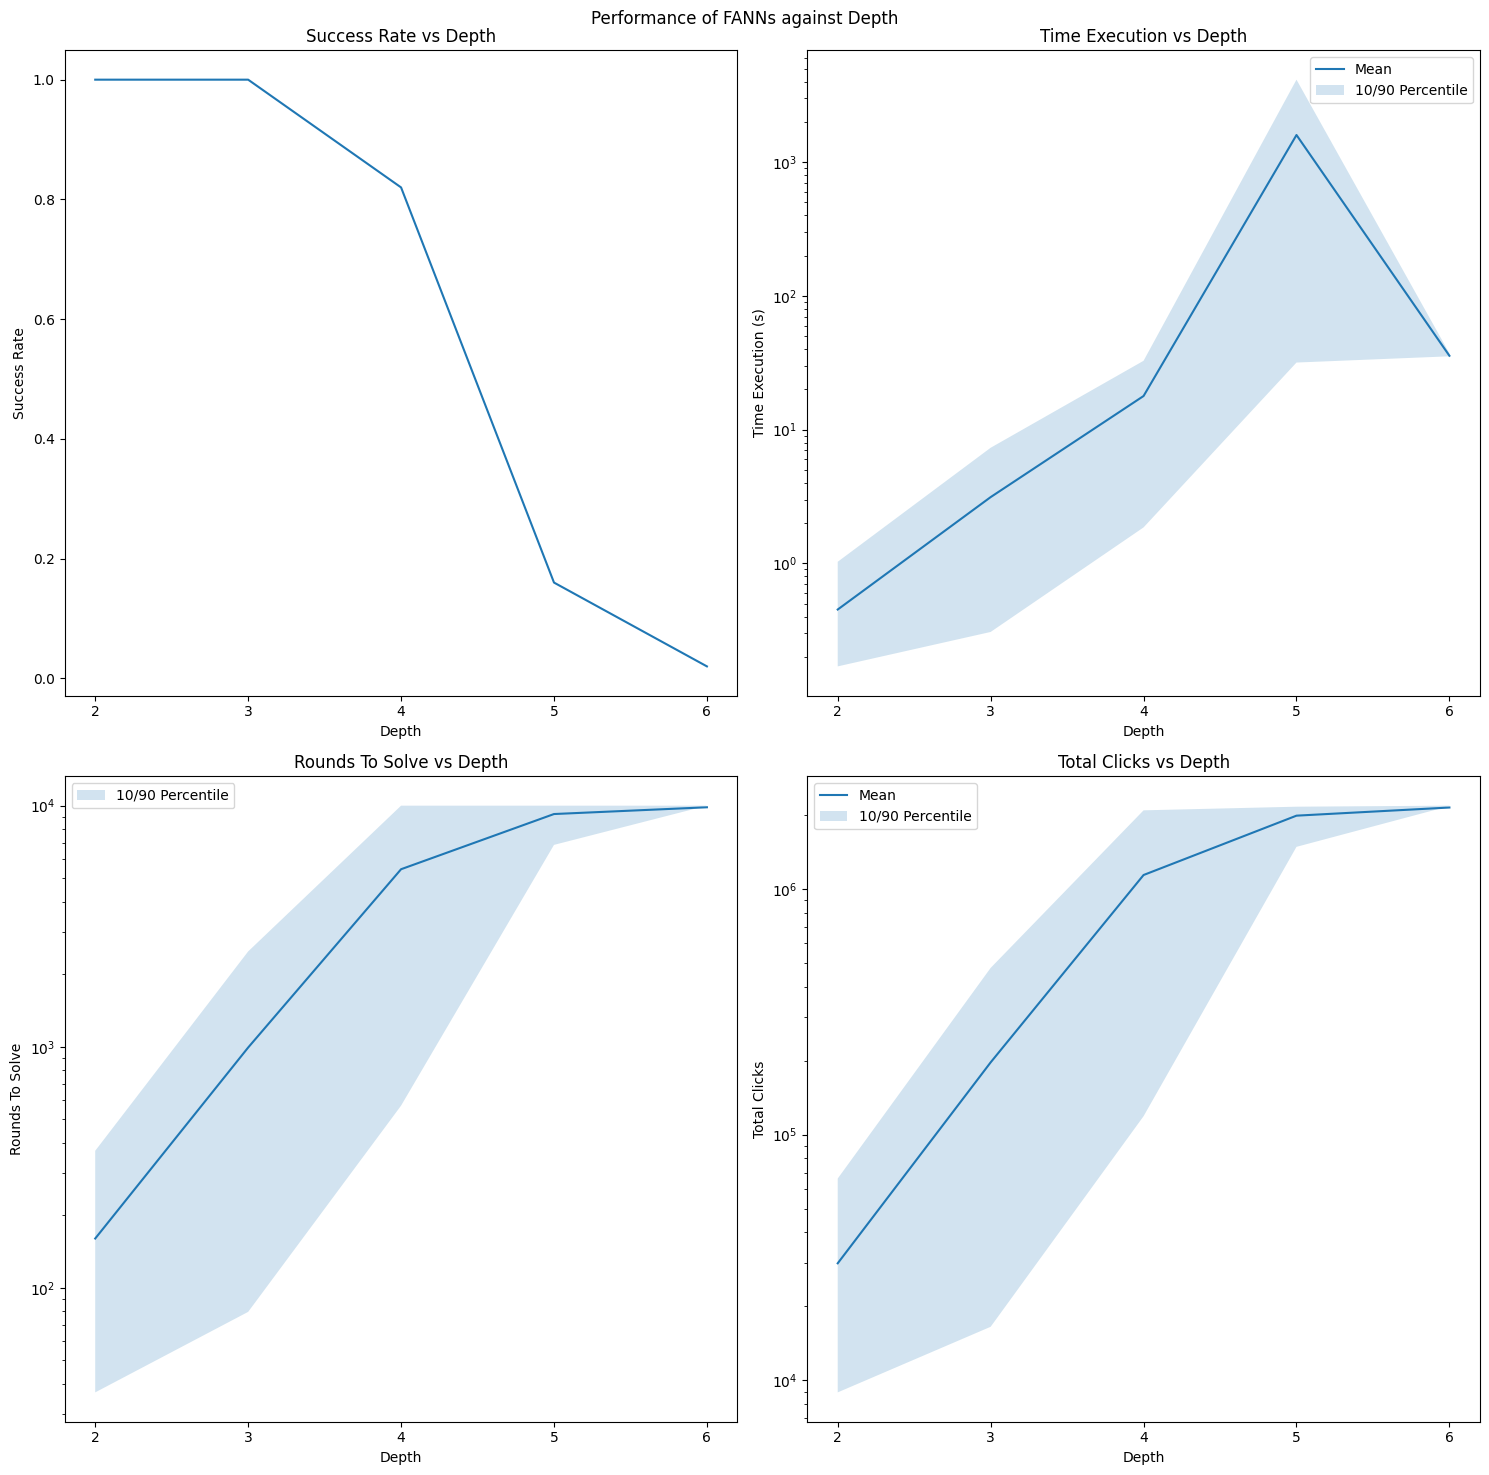

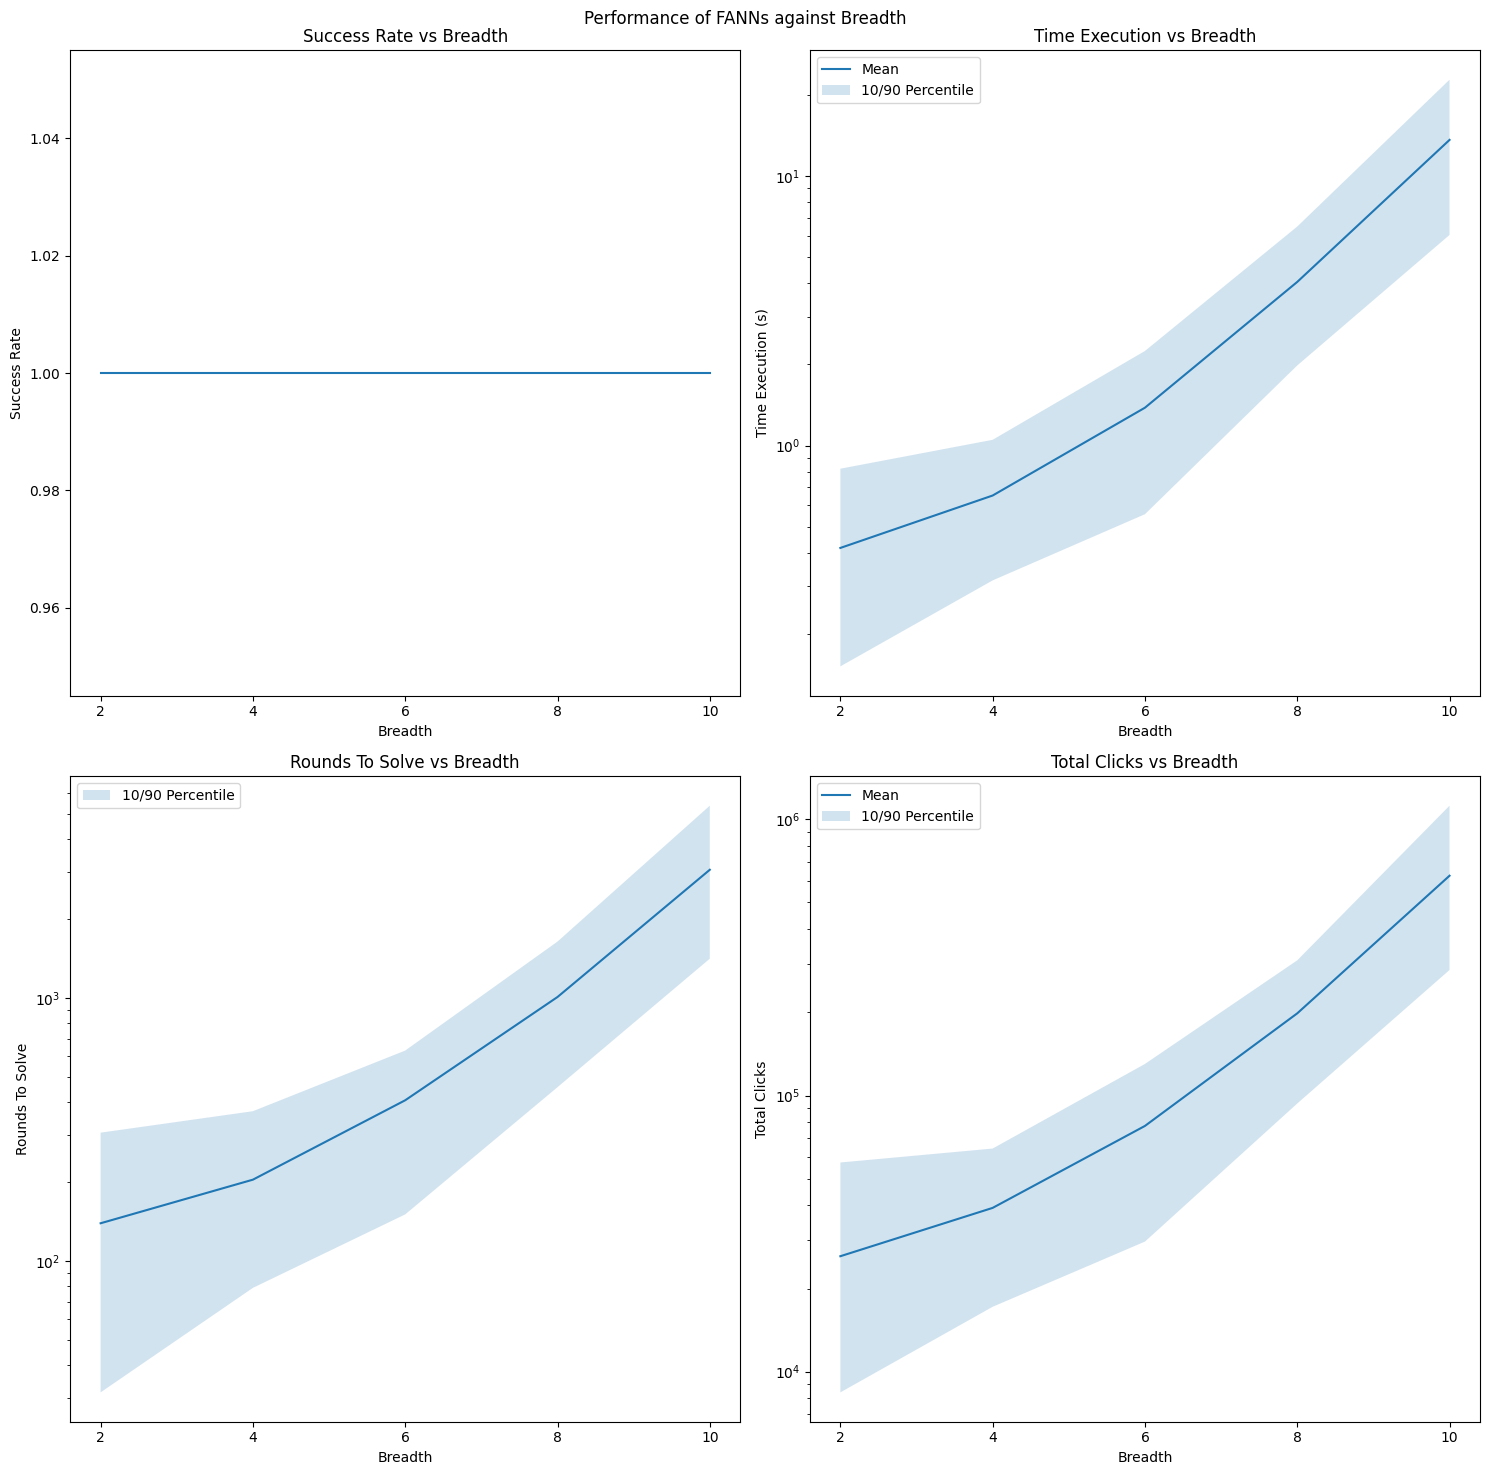

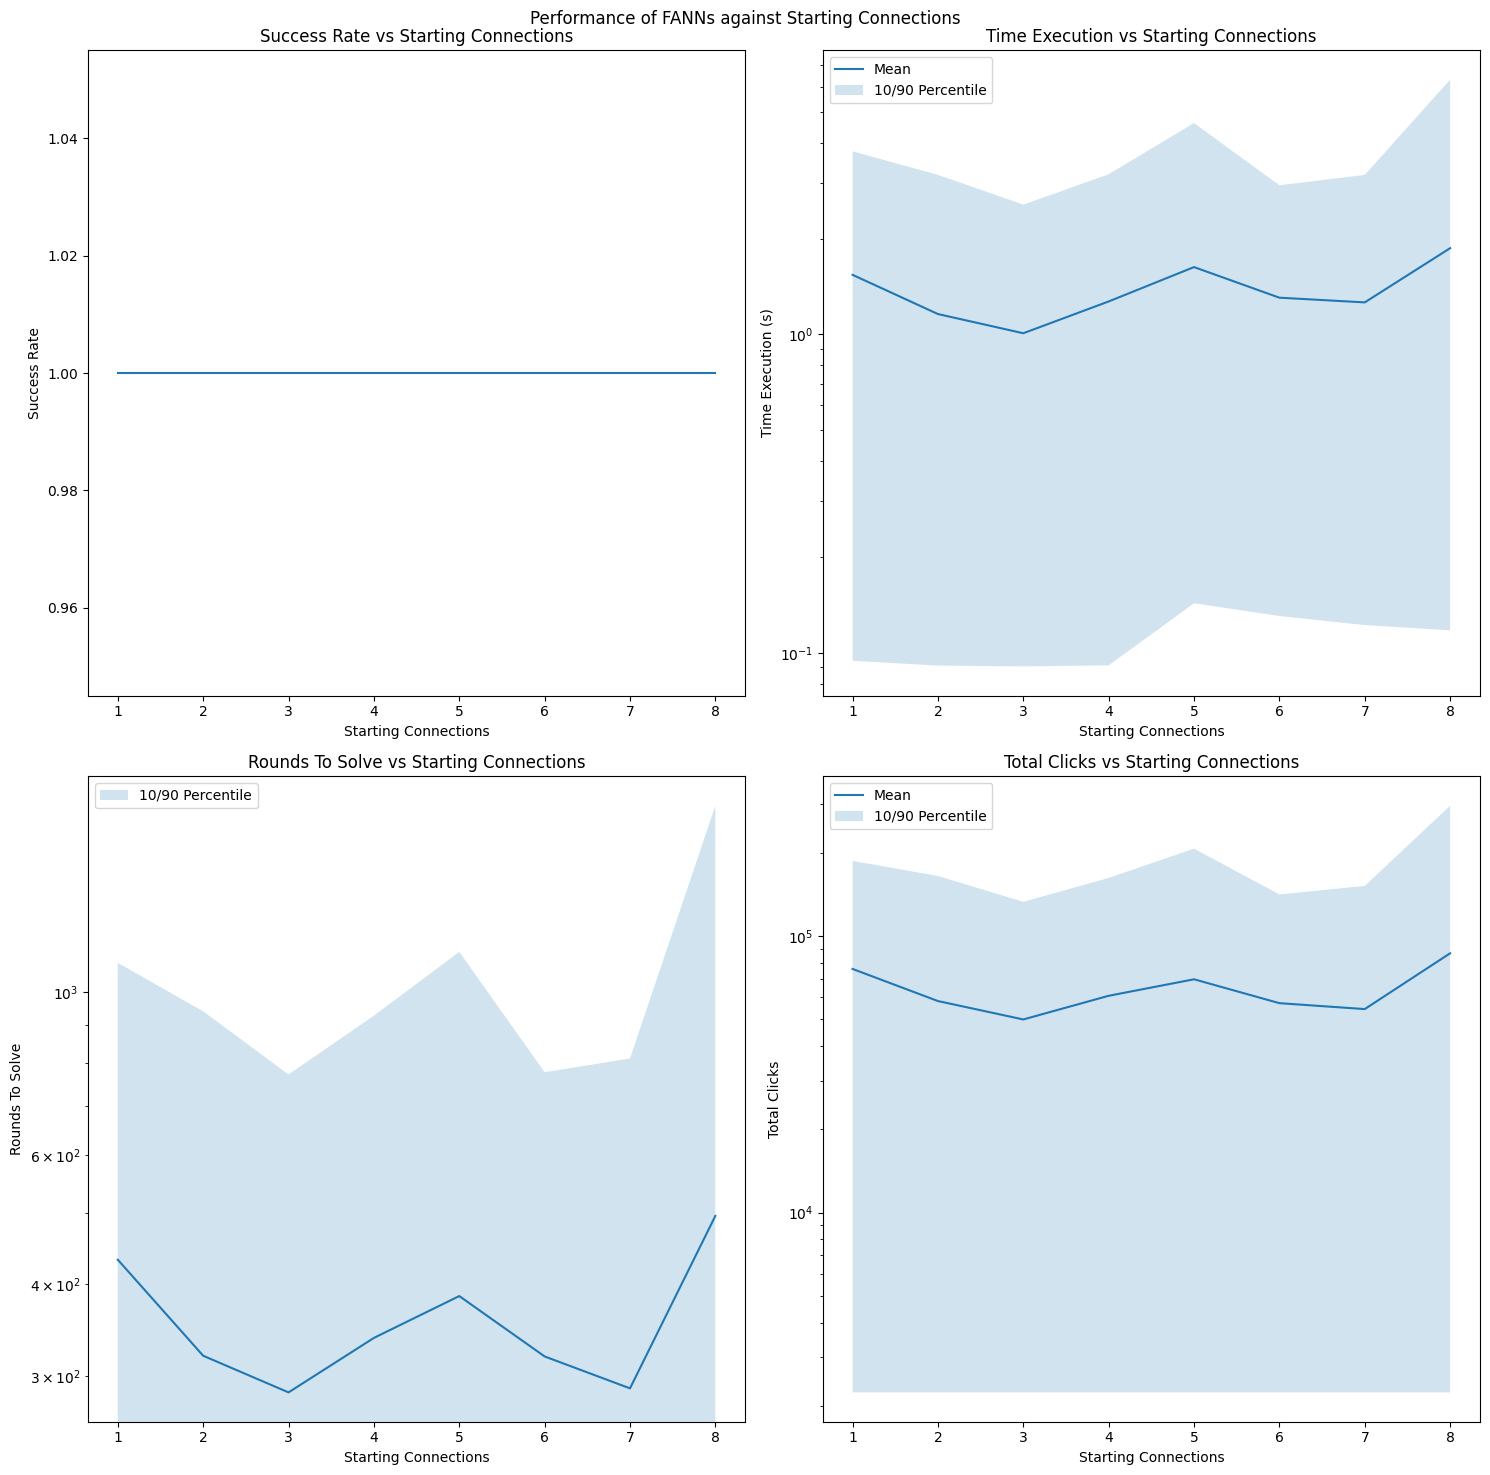

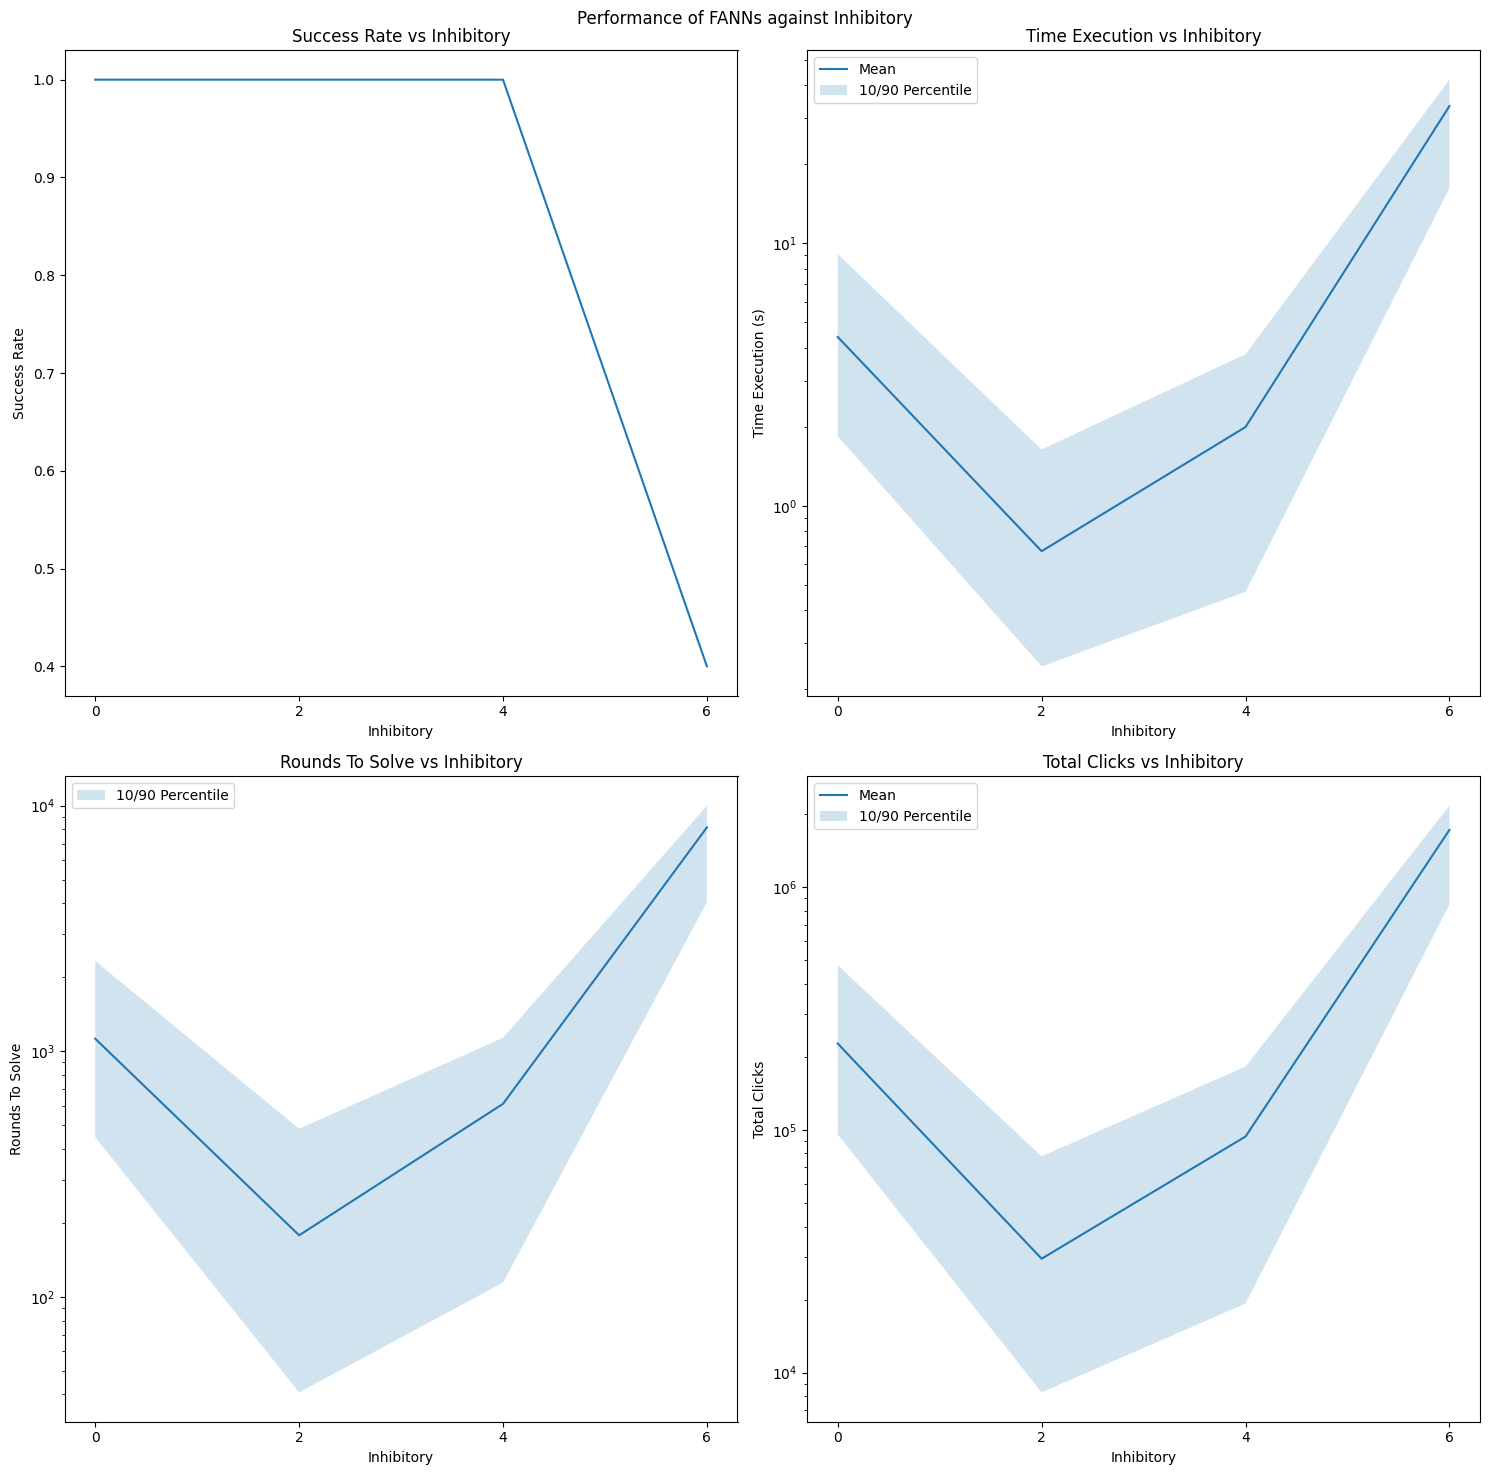

In [126]:
def investigate_depth():
    structures = [
        (2,2),
        (2,2,2),
        (2,2,2,2),
        (2,2,2,2,2),
        (2,2,2,2,2,2),
    ]
    cached_results = get_cache_results('depth_results')
    if cached_results is None:
        results = investigate_binary_classification(50, structures=structures)
        set_cache_results('depth_results', results)
    else:
        results = cached_results
    graph_results(results, [len(structure) for structure in structures], 'Depth')

def investigate_breadth():
    structures = [
        (2,2),
        (4,4),
        (6,6),
        (8,8),
        (10,10),
    ]
    cached_results = get_cache_results('breadth_results')
    if cached_results is None:
        results = investigate_binary_classification(50, structures=structures)
        set_cache_results('breadth_results', results)
    else:
        results = cached_results
    graph_results(results, [structure[0] for structure in structures], 'Breadth')

def investigate_starting_connections():
    structures = [
        (8,8),
    ]
    restructure_nums = [i for i in range(1,9)]
    cached_results = get_cache_results('starting_connections_results')
    if cached_results is None:
        results = investigate_binary_classification(50, structures=structures, restructure=True, restructure_nums=restructure_nums)
        set_cache_results('starting_connections_results', results)
    else:
        results = cached_results
    graph_results(results, restructure_nums, 'Starting Connections')

def investigate_inhibitory():
    inhibitories = [
        [],
        [3,7],
        [2,3,6,7],
        [1,2,3,5,6,7],
    ]
    cached_results = get_cache_results('inhibitory_results')
    num_rounds = 25
    results = {
        'inhibitory': [],
        'mean_successes': [],
        'mean_time_executions': [],
        '10_percentile_time_executions': [],
        '90_percentile_time_executions': [],
        'mean_correct_count': [],
        'mean_correct_since': [],
        '10_percentile_correct_since': [],
        '90_percentile_correct_since': [],
        'mean_total_clicks': [],
        '10_percentile_total_clicks': [],
        '90_percentile_total_clicks': [],
    }

    if cached_results is None:
        for inh_i in range(len(inhibitories)):
            curr_results = {
                'successes': [],
                'time_executions': [],
                'correct_count': [],
                'correct_since': [],
                'total_clicks': [],
            }
            for round_i in range(num_rounds):
                G,pos,_,inputs,all_inputs,outputs,all_outputs,_ = make_network(2, [8,8])
                inhibitory = np.zeros(16).astype(bool)
                inhibitory[inhibitories[inh_i]] = True
                fann = FANN(G, pos, inputs, all_inputs, outputs, all_outputs, inhibitory, verbose=False)
                success, time_execution, correct, correct_since, t, A = fann.run()
                curr_results['successes'].append(success)
                curr_results['time_executions'].append(time_execution)
                curr_results['correct_count'].append(correct)
                curr_results['correct_since'].append(correct_since)
                curr_results['total_clicks'].append(t)
            results['inhibitory'].append(inhibitories[inh_i])
            results['mean_successes'].append(np.mean(curr_results['successes']))
            results['mean_time_executions'].append(np.mean(curr_results['time_executions']))
            results['10_percentile_time_executions'].append(np.percentile(curr_results['time_executions'], 10))
            results['90_percentile_time_executions'].append(np.percentile(curr_results['time_executions'], 90))
            results['mean_correct_count'].append(np.mean(curr_results['correct_count']))
            results['mean_correct_since'].append(np.mean(curr_results['correct_since']))
            results['10_percentile_correct_since'].append(np.percentile(curr_results['correct_since'], 10))
            results['90_percentile_correct_since'].append(np.percentile(curr_results['correct_since'], 90))
            results['mean_total_clicks'].append(np.mean(curr_results['total_clicks']))
            results['10_percentile_total_clicks'].append(np.percentile(curr_results['total_clicks'], 10))
            results['90_percentile_total_clicks'].append(np.percentile(curr_results['total_clicks'], 90))

        set_cache_results('inhibitory_results', results)
    else:
        results = cached_results
    graph_results(results, [0,2,4,6], 'Inhibitory')

investigate_depth()
investigate_breadth()
investigate_starting_connections()
investigate_inhibitory()

### Tri-Class Classification Connection Evolution

/Users/Xaver.Davey/gooze/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Xaver.Davey/gooze/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/Xaver.Davey/gooze/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


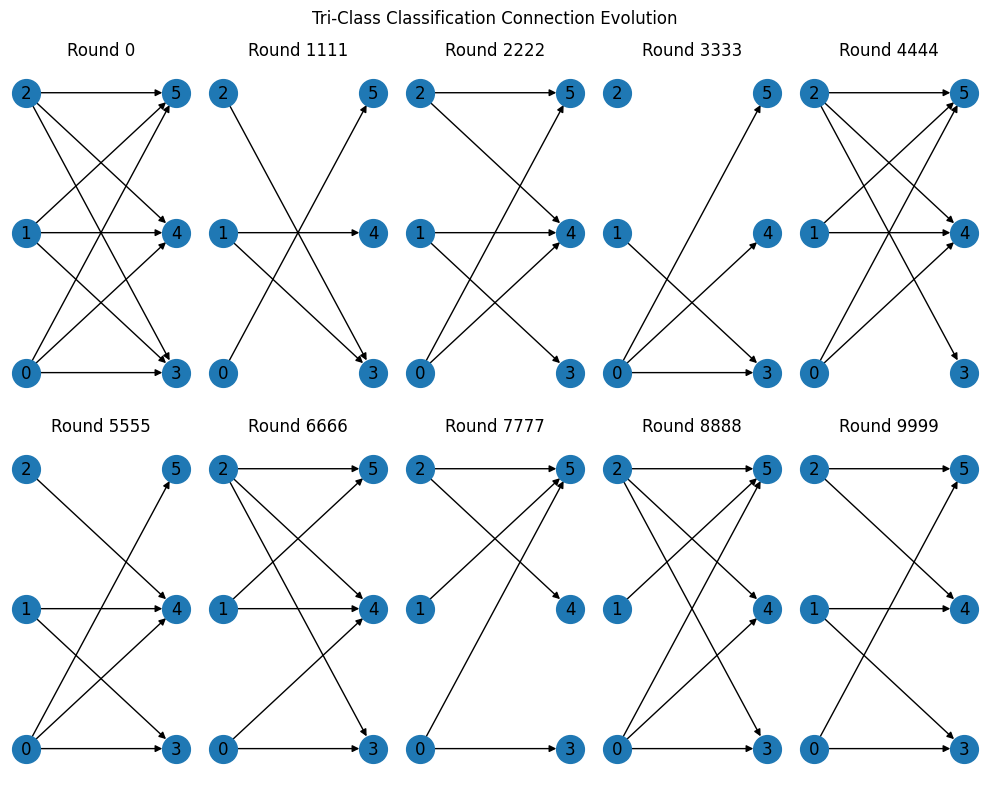

In [128]:
def investigate_tri_class_classification():
    G,pos,N,inputs,all_inputs,outputs,all_outputs,inhibitory = make_network(3, [3,3])
    fann = FANN(G, pos, inputs, all_inputs, outputs, all_outputs, inhibitory, verbose=False)
    fann.run()
    fann.connection_plt(frames=10, structure=(2,5), figsize=(10,8), node_size=400, title='Tri-Class Classification Connection Evolution')
    
investigate_tri_class_classification()

### Quad-Class Classification Connection Evolution

/Users/Xaver.Davey/gooze/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Xaver.Davey/gooze/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/Xaver.Davey/gooze/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


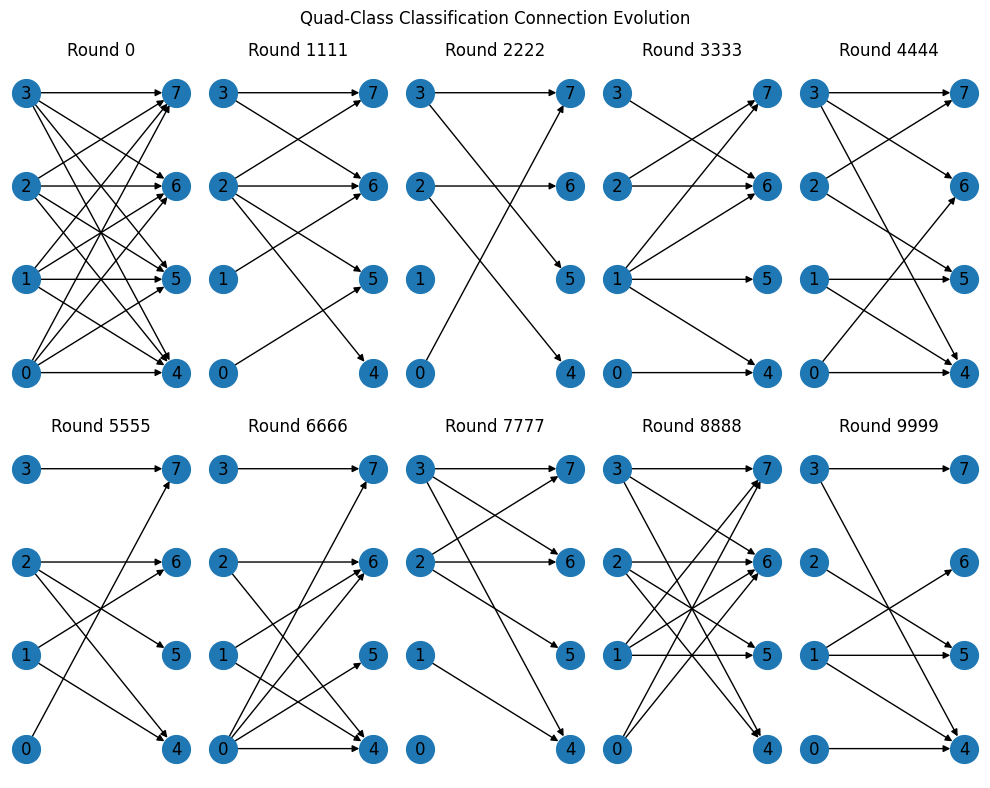

In [129]:
def investigate_quad_class_classification():
    G,pos,N,inputs,all_inputs,outputs,all_outputs,inhibitory = make_network(4, [4,4])
    fann = FANN(G, pos, inputs, all_inputs, outputs, all_outputs, inhibitory, verbose=False)
    fann.run()
    fann.connection_plt(frames=10, structure=(2,5), figsize=(10,8), node_size=400, title='Quad-Class Classification Connection Evolution')
    
investigate_quad_class_classification()

### Extra (Unused)

In [127]:
def investigate_or_gate():
    G = nx.from_numpy_array(np.array([[0,0,1,1],[0,0,1,1],[0,0,0,0],[0,0,0,0]]).astype('bool'), create_using=nx.DiGraph)
    pos = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
    inputs = {0: [], 1: [0], 2: [1], 3: [0,1]}
    all_inputs = set([0,1])
    outputs = {0: [2], 1: [2], 2: [2], 3: [3]}
    all_outputs = set([2,3])
    inhibitory = np.array([False, False, False, False])
    fann = FANN(G, pos, inputs, all_inputs, outputs, all_outputs, inhibitory, verbose=True)
    fann.draw()
    print(fann.s)
    fann.run()
    fann.summary_plot()
    
#investigate_or_gate()